# 2021- 5A-IBD - Unsupervised Machine Learning 


# Librairies

In [41]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.models import load_model



## Load data 

In [2]:
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

## GAN Model

In [3]:
# model discriminateur 
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



In [4]:
# model generateur
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model



In [5]:
# combiner generator et discriminateur
def define_gan(g_model, d_model):

    d_model.trainable = False

    model = Sequential()

    model.add(g_model)

    model.add(d_model)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



In [6]:
def generate_real_samples(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]

    y = ones((n_samples, 1))
    return X, y

In [7]:
#generation de point dans l'espace latent input g
def generate_latent_points(latent_dim, n_samples):

    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

#generateur de fausse image
def generate_fake_samples(g_model, latent_dim, n_samples):

    x_input = generate_latent_points(latent_dim, n_samples)

    X = g_model.predict(x_input)

    y = zeros((n_samples, 1))
    return X, y



In [8]:
# ploter generated image
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'g_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluation du discriminateur
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):

    X_real, y_real = generate_real_samples(dataset, n_samples)

    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy d image réel: %.0f%%, fausse: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)



In [13]:

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):

        for j in range(bat_per_epo):

            X_real, y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)



In [14]:
latent_dim = 10

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/781, d1=0.694, d2=0.695 g=0.692
>1, 2/781, d1=0.630, d2=0.696 g=0.691
>1, 3/781, d1=0.563, d2=0.699 g=0.689
>1, 4/781, d1=0.475, d2=0.706 g=0.682
>1, 5/781, d1=0.360, d2=0.725 g=0.666
>1, 6/781, d1=0.237, d2=0.765 g=0.638
>1, 7/781, d1=0.125, d2=0.838 g=0.593
>1, 8/781, d1=0.083, d2=0.924 g=0.574
>1, 9/781, d1=0.089, d2=0.933 g=0.582
>1, 10/781, d1=0.119, d2=0.868 g=0.640
>1, 11/781, d1=0.122, d2=0.753 g=0.752
>1, 12/781, d1=0.116, d2=0.610 g=0.899
>1, 13/781, d1=0.081, d2=0.515 g=1.040
>1, 14/781, d1=0.166, d2=0.494 g=1.041
>1, 15/781, d1=0.156, d2=0.519 g=0.947
>1, 16/781, d1=0.245, d2=0.579 g=0.839
>1, 17/781, d1=0.148, d2=0.611 g=0.790
>1, 18/781, d1=0.072, d2=0.623 g=0.782
>1, 19/781, d1=0.073, d2=0.626 g=0.778
>1, 20/781, d1=0.062, d2=0.632 g=0.781
>1, 21/781, d1=0.013, d2=0.628 g=0.796
>1, 22/781, d1=0.018, d2=0.615 g=0.816
>1, 23/781, d1=0.011, d2=0.625 g=0.839
>1, 24/781, d1=0.013, d2=0.666 g=0.867
>1, 25/781, d1=0.027, d2=0.726 g=0.862
>1, 26/781, d1=0.022, d2=0.867 g=0

>1, 209/781, d1=0.294, d2=0.131 g=3.165
>1, 210/781, d1=0.192, d2=0.213 g=4.049
>1, 211/781, d1=0.346, d2=0.114 g=4.090
>1, 212/781, d1=0.101, d2=0.218 g=7.033
>1, 213/781, d1=1.143, d2=0.082 g=3.514
>1, 214/781, d1=0.565, d2=0.907 g=7.324
>1, 215/781, d1=1.414, d2=0.005 g=6.441
>1, 216/781, d1=1.298, d2=0.039 g=3.407
>1, 217/781, d1=0.671, d2=0.250 g=1.954
>1, 218/781, d1=0.338, d2=0.276 g=2.219
>1, 219/781, d1=0.335, d2=0.199 g=2.550
>1, 220/781, d1=0.689, d2=0.362 g=2.328
>1, 221/781, d1=0.237, d2=0.168 g=2.674
>1, 222/781, d1=0.313, d2=0.167 g=2.295
>1, 223/781, d1=0.423, d2=0.202 g=2.397
>1, 224/781, d1=0.448, d2=0.303 g=2.128
>1, 225/781, d1=0.357, d2=0.190 g=2.236
>1, 226/781, d1=0.243, d2=0.223 g=2.464
>1, 227/781, d1=0.436, d2=0.226 g=2.527
>1, 228/781, d1=0.318, d2=0.195 g=2.548
>1, 229/781, d1=0.455, d2=0.230 g=2.436
>1, 230/781, d1=0.346, d2=0.150 g=2.622
>1, 231/781, d1=0.560, d2=0.181 g=2.317
>1, 232/781, d1=0.165, d2=0.152 g=2.583
>1, 233/781, d1=0.121, d2=0.109 g=3.026


>1, 414/781, d1=0.752, d2=0.378 g=1.581
>1, 415/781, d1=0.565, d2=0.350 g=1.615
>1, 416/781, d1=0.595, d2=0.401 g=1.433
>1, 417/781, d1=0.644, d2=0.375 g=1.481
>1, 418/781, d1=0.548, d2=0.496 g=1.620
>1, 419/781, d1=0.622, d2=0.385 g=1.649
>1, 420/781, d1=0.579, d2=0.308 g=1.562
>1, 421/781, d1=0.521, d2=0.367 g=1.513
>1, 422/781, d1=0.614, d2=0.437 g=1.520
>1, 423/781, d1=0.398, d2=0.367 g=1.668
>1, 424/781, d1=0.557, d2=0.303 g=1.719
>1, 425/781, d1=0.670, d2=0.405 g=1.637
>1, 426/781, d1=0.511, d2=0.390 g=1.615
>1, 427/781, d1=0.403, d2=0.322 g=1.582
>1, 428/781, d1=0.482, d2=0.343 g=1.547
>1, 429/781, d1=0.526, d2=0.395 g=1.739
>1, 430/781, d1=0.569, d2=0.378 g=1.478
>1, 431/781, d1=0.476, d2=0.449 g=1.546
>1, 432/781, d1=0.326, d2=0.430 g=1.655
>1, 433/781, d1=0.702, d2=0.421 g=1.425
>1, 434/781, d1=0.397, d2=0.499 g=1.381
>1, 435/781, d1=0.424, d2=0.485 g=1.526
>1, 436/781, d1=0.534, d2=0.518 g=1.536
>1, 437/781, d1=0.408, d2=0.329 g=1.641
>1, 438/781, d1=0.570, d2=0.407 g=1.472


>1, 619/781, d1=0.482, d2=0.657 g=1.019
>1, 620/781, d1=0.605, d2=0.676 g=0.994
>1, 621/781, d1=0.398, d2=0.592 g=0.965
>1, 622/781, d1=0.380, d2=0.536 g=1.146
>1, 623/781, d1=0.321, d2=0.476 g=1.418
>1, 624/781, d1=0.394, d2=0.392 g=1.392
>1, 625/781, d1=0.329, d2=0.477 g=1.552
>1, 626/781, d1=0.332, d2=0.351 g=1.598
>1, 627/781, d1=0.504, d2=0.357 g=1.460
>1, 628/781, d1=0.415, d2=0.391 g=1.578
>1, 629/781, d1=0.340, d2=0.439 g=1.545
>1, 630/781, d1=0.346, d2=0.369 g=1.701
>1, 631/781, d1=0.366, d2=0.388 g=1.793
>1, 632/781, d1=0.351, d2=0.360 g=2.023
>1, 633/781, d1=0.457, d2=0.298 g=1.822
>1, 634/781, d1=0.541, d2=0.402 g=1.705
>1, 635/781, d1=0.486, d2=0.449 g=2.057
>1, 636/781, d1=0.506, d2=0.296 g=2.134
>1, 637/781, d1=0.580, d2=0.412 g=1.880
>1, 638/781, d1=0.364, d2=0.239 g=2.082
>1, 639/781, d1=0.442, d2=0.430 g=1.989
>1, 640/781, d1=0.429, d2=0.243 g=2.172
>1, 641/781, d1=0.424, d2=0.338 g=1.999
>1, 642/781, d1=0.378, d2=0.265 g=2.196
>1, 643/781, d1=0.544, d2=0.283 g=2.055


>2, 45/781, d1=0.372, d2=0.385 g=2.249
>2, 46/781, d1=0.513, d2=0.303 g=2.010
>2, 47/781, d1=0.368, d2=0.296 g=2.192
>2, 48/781, d1=0.345, d2=0.255 g=2.023
>2, 49/781, d1=0.415, d2=0.405 g=2.166
>2, 50/781, d1=0.521, d2=0.294 g=1.830
>2, 51/781, d1=0.364, d2=0.529 g=1.871
>2, 52/781, d1=0.522, d2=0.410 g=1.874
>2, 53/781, d1=0.546, d2=0.510 g=1.907
>2, 54/781, d1=0.836, d2=0.717 g=1.670
>2, 55/781, d1=0.820, d2=0.484 g=1.631
>2, 56/781, d1=0.792, d2=0.438 g=1.664
>2, 57/781, d1=0.749, d2=0.578 g=1.649
>2, 58/781, d1=0.352, d2=0.342 g=1.740
>2, 59/781, d1=0.497, d2=0.455 g=1.948
>2, 60/781, d1=0.655, d2=0.461 g=1.762
>2, 61/781, d1=0.467, d2=0.530 g=1.958
>2, 62/781, d1=0.788, d2=0.557 g=2.158
>2, 63/781, d1=0.849, d2=0.466 g=2.040
>2, 64/781, d1=0.798, d2=0.464 g=2.123
>2, 65/781, d1=0.558, d2=0.337 g=2.132
>2, 66/781, d1=0.647, d2=0.517 g=2.236
>2, 67/781, d1=0.580, d2=0.361 g=2.414
>2, 68/781, d1=0.796, d2=0.726 g=2.167
>2, 69/781, d1=0.825, d2=0.397 g=2.007
>2, 70/781, d1=0.992, d2=

>2, 252/781, d1=0.549, d2=0.419 g=1.735
>2, 253/781, d1=0.756, d2=0.430 g=1.619
>2, 254/781, d1=0.530, d2=0.457 g=1.747
>2, 255/781, d1=0.585, d2=0.470 g=1.752
>2, 256/781, d1=0.448, d2=0.474 g=1.825
>2, 257/781, d1=0.544, d2=0.409 g=1.648
>2, 258/781, d1=0.526, d2=0.494 g=1.494
>2, 259/781, d1=0.514, d2=0.495 g=1.441
>2, 260/781, d1=0.493, d2=0.588 g=1.522
>2, 261/781, d1=0.520, d2=0.455 g=1.467
>2, 262/781, d1=0.530, d2=0.585 g=1.753
>2, 263/781, d1=0.578, d2=0.382 g=1.709
>2, 264/781, d1=0.528, d2=0.543 g=1.648
>2, 265/781, d1=0.491, d2=0.490 g=1.648
>2, 266/781, d1=0.618, d2=0.604 g=1.846
>2, 267/781, d1=0.369, d2=0.363 g=1.935
>2, 268/781, d1=0.601, d2=0.538 g=1.884
>2, 269/781, d1=0.544, d2=0.512 g=1.549
>2, 270/781, d1=0.503, d2=0.537 g=1.588
>2, 271/781, d1=0.541, d2=0.564 g=1.893
>2, 272/781, d1=0.514, d2=0.383 g=1.787
>2, 273/781, d1=0.661, d2=0.460 g=1.563
>2, 274/781, d1=0.546, d2=0.567 g=1.419
>2, 275/781, d1=0.633, d2=0.601 g=1.624
>2, 276/781, d1=0.732, d2=0.547 g=1.595


>2, 457/781, d1=0.465, d2=0.533 g=1.482
>2, 458/781, d1=0.525, d2=0.493 g=1.456
>2, 459/781, d1=0.561, d2=0.631 g=1.385
>2, 460/781, d1=0.630, d2=0.632 g=1.343
>2, 461/781, d1=0.497, d2=0.725 g=1.239
>2, 462/781, d1=0.793, d2=0.661 g=1.381
>2, 463/781, d1=0.814, d2=0.586 g=1.281
>2, 464/781, d1=0.681, d2=0.630 g=1.313
>2, 465/781, d1=0.717, d2=0.657 g=1.407
>2, 466/781, d1=0.755, d2=0.551 g=1.433
>2, 467/781, d1=0.567, d2=0.465 g=1.434
>2, 468/781, d1=0.663, d2=0.424 g=1.441
>2, 469/781, d1=0.517, d2=0.446 g=1.543
>2, 470/781, d1=0.666, d2=0.475 g=1.422
>2, 471/781, d1=0.593, d2=0.468 g=1.369
>2, 472/781, d1=0.419, d2=0.358 g=1.534
>2, 473/781, d1=0.484, d2=0.458 g=1.506
>2, 474/781, d1=0.384, d2=0.546 g=1.523
>2, 475/781, d1=0.483, d2=0.486 g=1.502
>2, 476/781, d1=0.500, d2=0.466 g=1.531
>2, 477/781, d1=0.476, d2=0.442 g=1.500
>2, 478/781, d1=0.522, d2=0.455 g=1.318
>2, 479/781, d1=0.412, d2=0.705 g=1.452
>2, 480/781, d1=0.567, d2=0.467 g=1.408
>2, 481/781, d1=0.623, d2=0.478 g=1.353


>2, 662/781, d1=0.701, d2=0.578 g=1.441
>2, 663/781, d1=0.671, d2=0.603 g=1.477
>2, 664/781, d1=0.649, d2=0.567 g=1.470
>2, 665/781, d1=0.725, d2=0.474 g=1.363
>2, 666/781, d1=0.790, d2=0.590 g=1.193
>2, 667/781, d1=0.390, d2=0.499 g=1.346
>2, 668/781, d1=0.575, d2=0.511 g=1.295
>2, 669/781, d1=0.384, d2=0.480 g=1.423
>2, 670/781, d1=0.423, d2=0.398 g=1.448
>2, 671/781, d1=0.629, d2=0.484 g=1.356
>2, 672/781, d1=0.361, d2=0.463 g=1.455
>2, 673/781, d1=0.530, d2=0.532 g=1.492
>2, 674/781, d1=0.454, d2=0.480 g=1.534
>2, 675/781, d1=0.389, d2=0.423 g=1.420
>2, 676/781, d1=0.357, d2=0.563 g=1.466
>2, 677/781, d1=0.537, d2=0.522 g=1.453
>2, 678/781, d1=0.471, d2=0.438 g=1.231
>2, 679/781, d1=0.485, d2=0.652 g=1.386
>2, 680/781, d1=0.415, d2=0.408 g=1.356
>2, 681/781, d1=0.545, d2=0.541 g=1.462
>2, 682/781, d1=0.416, d2=0.431 g=1.338
>2, 683/781, d1=0.403, d2=0.438 g=1.324
>2, 684/781, d1=0.366, d2=0.435 g=1.469
>2, 685/781, d1=0.328, d2=0.451 g=1.521
>2, 686/781, d1=0.365, d2=0.425 g=1.415


>3, 89/781, d1=0.337, d2=0.524 g=1.319
>3, 90/781, d1=0.352, d2=0.590 g=1.385
>3, 91/781, d1=0.411, d2=0.501 g=1.360
>3, 92/781, d1=0.589, d2=0.519 g=1.204
>3, 93/781, d1=0.472, d2=0.622 g=1.177
>3, 94/781, d1=0.523, d2=0.672 g=1.261
>3, 95/781, d1=0.574, d2=0.653 g=1.250
>3, 96/781, d1=0.711, d2=0.649 g=1.227
>3, 97/781, d1=0.639, d2=0.554 g=1.240
>3, 98/781, d1=0.611, d2=0.639 g=1.465
>3, 99/781, d1=0.697, d2=0.395 g=1.369
>3, 100/781, d1=0.537, d2=0.487 g=1.381
>3, 101/781, d1=0.496, d2=0.482 g=1.745
>3, 102/781, d1=0.483, d2=0.332 g=1.763
>3, 103/781, d1=0.341, d2=0.366 g=1.867
>3, 104/781, d1=0.407, d2=0.293 g=1.837
>3, 105/781, d1=0.523, d2=0.572 g=1.664
>3, 106/781, d1=0.348, d2=0.415 g=1.738
>3, 107/781, d1=0.396, d2=0.399 g=1.619
>3, 108/781, d1=0.463, d2=0.508 g=1.649
>3, 109/781, d1=0.331, d2=0.452 g=1.696
>3, 110/781, d1=0.626, d2=0.409 g=1.555
>3, 111/781, d1=0.401, d2=0.448 g=1.557
>3, 112/781, d1=0.552, d2=0.416 g=1.504
>3, 113/781, d1=0.446, d2=0.579 g=1.446
>3, 114/781

>3, 295/781, d1=0.517, d2=0.514 g=1.589
>3, 296/781, d1=0.605, d2=0.508 g=1.589
>3, 297/781, d1=0.390, d2=0.480 g=1.463
>3, 298/781, d1=0.584, d2=0.541 g=1.378
>3, 299/781, d1=0.506, d2=0.498 g=1.191
>3, 300/781, d1=0.527, d2=0.586 g=1.304
>3, 301/781, d1=0.729, d2=0.741 g=1.443
>3, 302/781, d1=0.800, d2=0.445 g=1.465
>3, 303/781, d1=0.656, d2=0.640 g=1.285
>3, 304/781, d1=0.560, d2=0.463 g=1.356
>3, 305/781, d1=0.444, d2=0.419 g=1.570
>3, 306/781, d1=0.527, d2=0.377 g=1.367
>3, 307/781, d1=0.465, d2=0.473 g=1.364
>3, 308/781, d1=0.608, d2=0.509 g=1.307
>3, 309/781, d1=0.425, d2=0.610 g=1.499
>3, 310/781, d1=0.650, d2=0.482 g=1.408
>3, 311/781, d1=0.537, d2=0.545 g=1.208
>3, 312/781, d1=0.607, d2=0.565 g=1.130
>3, 313/781, d1=0.426, d2=0.852 g=1.292
>3, 314/781, d1=0.856, d2=0.605 g=1.360
>3, 315/781, d1=0.724, d2=0.419 g=1.370
>3, 316/781, d1=0.709, d2=0.521 g=1.298
>3, 317/781, d1=0.566, d2=0.433 g=1.277
>3, 318/781, d1=0.490, d2=0.496 g=1.317
>3, 319/781, d1=0.432, d2=0.495 g=1.369


>3, 500/781, d1=0.570, d2=0.587 g=1.558
>3, 501/781, d1=0.605, d2=0.575 g=1.615
>3, 502/781, d1=0.784, d2=0.531 g=1.403
>3, 503/781, d1=0.839, d2=0.531 g=1.142
>3, 504/781, d1=0.652, d2=0.769 g=1.473
>3, 505/781, d1=0.563, d2=0.457 g=1.600
>3, 506/781, d1=0.641, d2=0.524 g=1.534
>3, 507/781, d1=0.710, d2=0.533 g=1.481
>3, 508/781, d1=0.923, d2=0.473 g=1.477
>3, 509/781, d1=0.750, d2=0.870 g=1.700
>3, 510/781, d1=0.747, d2=0.393 g=1.578
>3, 511/781, d1=0.843, d2=0.381 g=1.416
>3, 512/781, d1=0.704, d2=0.479 g=1.424
>3, 513/781, d1=0.535, d2=0.520 g=1.617
>3, 514/781, d1=0.583, d2=0.383 g=1.714
>3, 515/781, d1=0.675, d2=0.358 g=1.583
>3, 516/781, d1=0.668, d2=0.516 g=1.550
>3, 517/781, d1=0.499, d2=0.608 g=1.736
>3, 518/781, d1=0.535, d2=0.403 g=1.667
>3, 519/781, d1=0.477, d2=0.621 g=1.481
>3, 520/781, d1=0.486, d2=0.437 g=1.489
>3, 521/781, d1=0.643, d2=0.409 g=1.261
>3, 522/781, d1=0.692, d2=0.720 g=1.264
>3, 523/781, d1=0.810, d2=0.704 g=1.162
>3, 524/781, d1=0.831, d2=0.621 g=1.102


>3, 705/781, d1=0.564, d2=0.548 g=1.251
>3, 706/781, d1=0.616, d2=0.553 g=1.294
>3, 707/781, d1=0.509, d2=0.598 g=1.444
>3, 708/781, d1=0.658, d2=0.499 g=1.406
>3, 709/781, d1=0.488, d2=0.545 g=1.327
>3, 710/781, d1=0.472, d2=0.547 g=1.494
>3, 711/781, d1=0.385, d2=0.375 g=1.442
>3, 712/781, d1=0.519, d2=0.662 g=1.625
>3, 713/781, d1=0.550, d2=0.444 g=1.753
>3, 714/781, d1=0.907, d2=0.339 g=1.618
>3, 715/781, d1=0.719, d2=0.576 g=1.404
>3, 716/781, d1=0.391, d2=0.454 g=1.603
>3, 717/781, d1=0.437, d2=0.536 g=1.785
>3, 718/781, d1=0.692, d2=0.343 g=1.567
>3, 719/781, d1=0.586, d2=0.550 g=1.533
>3, 720/781, d1=0.533, d2=0.384 g=1.332
>3, 721/781, d1=0.414, d2=0.598 g=1.470
>3, 722/781, d1=0.489, d2=0.426 g=1.488
>3, 723/781, d1=0.513, d2=0.400 g=1.360
>3, 724/781, d1=0.566, d2=0.591 g=1.297
>3, 725/781, d1=0.409, d2=0.458 g=1.408
>3, 726/781, d1=0.578, d2=0.558 g=1.300
>3, 727/781, d1=0.548, d2=0.514 g=1.231
>3, 728/781, d1=0.561, d2=0.611 g=1.162
>3, 729/781, d1=0.567, d2=0.593 g=1.267


>4, 132/781, d1=0.715, d2=0.466 g=1.221
>4, 133/781, d1=0.649, d2=0.598 g=1.252
>4, 134/781, d1=0.655, d2=0.537 g=1.240
>4, 135/781, d1=0.742, d2=0.589 g=1.195
>4, 136/781, d1=0.529, d2=0.423 g=1.152
>4, 137/781, d1=0.580, d2=0.481 g=1.210
>4, 138/781, d1=0.612, d2=0.620 g=1.288
>4, 139/781, d1=0.603, d2=0.481 g=1.199
>4, 140/781, d1=0.601, d2=0.391 g=1.284
>4, 141/781, d1=0.758, d2=0.614 g=1.161
>4, 142/781, d1=0.550, d2=0.589 g=1.191
>4, 143/781, d1=0.535, d2=0.557 g=1.327
>4, 144/781, d1=0.649, d2=0.426 g=1.420
>4, 145/781, d1=0.695, d2=0.450 g=1.288
>4, 146/781, d1=0.630, d2=0.533 g=1.179
>4, 147/781, d1=0.559, d2=0.597 g=1.304
>4, 148/781, d1=0.651, d2=0.455 g=1.395
>4, 149/781, d1=0.744, d2=0.454 g=1.325
>4, 150/781, d1=0.601, d2=0.498 g=1.125
>4, 151/781, d1=0.511, d2=0.527 g=1.254
>4, 152/781, d1=0.628, d2=0.422 g=1.400
>4, 153/781, d1=0.605, d2=0.595 g=1.176
>4, 154/781, d1=0.604, d2=0.553 g=1.326
>4, 155/781, d1=0.623, d2=0.448 g=1.259
>4, 156/781, d1=0.562, d2=0.557 g=1.360


>4, 337/781, d1=0.662, d2=0.679 g=1.227
>4, 338/781, d1=0.530, d2=0.730 g=1.468
>4, 339/781, d1=0.686, d2=0.471 g=1.434
>4, 340/781, d1=0.707, d2=0.375 g=1.522
>4, 341/781, d1=0.606, d2=0.545 g=1.473
>4, 342/781, d1=0.532, d2=0.620 g=1.485
>4, 343/781, d1=0.632, d2=0.551 g=1.473
>4, 344/781, d1=0.644, d2=0.439 g=1.446
>4, 345/781, d1=0.594, d2=0.555 g=1.351
>4, 346/781, d1=0.410, d2=0.609 g=1.290
>4, 347/781, d1=0.638, d2=0.409 g=1.400
>4, 348/781, d1=0.586, d2=0.488 g=1.179
>4, 349/781, d1=0.455, d2=0.500 g=1.210
>4, 350/781, d1=0.609, d2=0.537 g=1.275
>4, 351/781, d1=0.683, d2=0.631 g=1.181
>4, 352/781, d1=0.572, d2=0.606 g=1.106
>4, 353/781, d1=0.517, d2=0.640 g=1.311
>4, 354/781, d1=0.963, d2=0.470 g=1.243
>4, 355/781, d1=0.665, d2=0.598 g=1.265
>4, 356/781, d1=0.550, d2=0.545 g=1.237
>4, 357/781, d1=0.728, d2=0.541 g=1.334
>4, 358/781, d1=0.672, d2=0.519 g=1.171
>4, 359/781, d1=0.513, d2=0.627 g=1.310
>4, 360/781, d1=0.713, d2=0.587 g=1.158
>4, 361/781, d1=0.626, d2=0.532 g=1.377


>4, 542/781, d1=0.436, d2=0.552 g=1.237
>4, 543/781, d1=0.424, d2=0.594 g=1.167
>4, 544/781, d1=0.723, d2=0.550 g=1.085
>4, 545/781, d1=0.430, d2=0.553 g=1.074
>4, 546/781, d1=0.582, d2=0.716 g=1.097
>4, 547/781, d1=0.497, d2=0.589 g=1.060
>4, 548/781, d1=0.675, d2=0.669 g=1.114
>4, 549/781, d1=0.666, d2=0.544 g=1.117
>4, 550/781, d1=0.636, d2=0.590 g=1.225
>4, 551/781, d1=0.799, d2=0.462 g=1.223
>4, 552/781, d1=0.607, d2=0.550 g=1.265
>4, 553/781, d1=0.572, d2=0.537 g=1.284
>4, 554/781, d1=0.527, d2=0.469 g=1.258
>4, 555/781, d1=0.662, d2=0.530 g=1.257
>4, 556/781, d1=0.554, d2=0.590 g=1.140
>4, 557/781, d1=0.615, d2=0.703 g=0.977
>4, 558/781, d1=0.566, d2=0.701 g=1.193
>4, 559/781, d1=0.569, d2=0.578 g=1.203
>4, 560/781, d1=0.802, d2=0.570 g=1.295
>4, 561/781, d1=0.644, d2=0.517 g=1.232
>4, 562/781, d1=0.809, d2=0.538 g=1.113
>4, 563/781, d1=0.651, d2=0.583 g=1.044
>4, 564/781, d1=0.599, d2=0.599 g=1.083
>4, 565/781, d1=0.624, d2=0.629 g=1.195
>4, 566/781, d1=0.714, d2=0.546 g=1.133


>4, 747/781, d1=0.771, d2=0.541 g=1.054
>4, 748/781, d1=0.568, d2=0.612 g=1.142
>4, 749/781, d1=0.662, d2=0.595 g=1.255
>4, 750/781, d1=0.742, d2=0.576 g=1.197
>4, 751/781, d1=0.714, d2=0.605 g=1.151
>4, 752/781, d1=0.505, d2=0.744 g=1.362
>4, 753/781, d1=0.705, d2=0.493 g=1.316
>4, 754/781, d1=0.792, d2=0.543 g=1.266
>4, 755/781, d1=0.996, d2=0.544 g=1.169
>4, 756/781, d1=0.566, d2=0.705 g=1.258
>4, 757/781, d1=0.748, d2=0.443 g=1.300
>4, 758/781, d1=0.729, d2=0.483 g=1.204
>4, 759/781, d1=0.702, d2=0.646 g=1.231
>4, 760/781, d1=0.618, d2=0.419 g=1.253
>4, 761/781, d1=0.494, d2=0.602 g=1.111
>4, 762/781, d1=0.828, d2=0.830 g=1.228
>4, 763/781, d1=0.580, d2=0.529 g=1.234
>4, 764/781, d1=0.776, d2=0.690 g=1.199
>4, 765/781, d1=0.698, d2=0.701 g=1.140
>4, 766/781, d1=0.768, d2=0.587 g=1.145
>4, 767/781, d1=0.713, d2=0.469 g=1.230
>4, 768/781, d1=0.753, d2=0.532 g=1.367
>4, 769/781, d1=0.741, d2=0.473 g=1.340
>4, 770/781, d1=0.582, d2=0.452 g=1.300
>4, 771/781, d1=0.492, d2=0.614 g=1.332


>5, 174/781, d1=0.551, d2=0.438 g=1.349
>5, 175/781, d1=0.693, d2=0.619 g=1.235
>5, 176/781, d1=0.518, d2=0.885 g=1.376
>5, 177/781, d1=0.527, d2=0.517 g=1.568
>5, 178/781, d1=0.730, d2=0.411 g=1.518
>5, 179/781, d1=0.829, d2=0.517 g=1.147
>5, 180/781, d1=0.601, d2=0.566 g=1.323
>5, 181/781, d1=0.640, d2=0.459 g=1.445
>5, 182/781, d1=0.556, d2=0.389 g=1.600
>5, 183/781, d1=0.639, d2=0.494 g=1.303
>5, 184/781, d1=0.525, d2=0.472 g=1.227
>5, 185/781, d1=0.645, d2=0.614 g=1.307
>5, 186/781, d1=0.554, d2=0.547 g=1.417
>5, 187/781, d1=0.553, d2=0.511 g=1.338
>5, 188/781, d1=0.578, d2=0.621 g=1.253
>5, 189/781, d1=0.631, d2=0.572 g=1.255
>5, 190/781, d1=0.732, d2=0.481 g=1.109
>5, 191/781, d1=0.552, d2=0.728 g=1.415
>5, 192/781, d1=0.803, d2=0.691 g=1.698
>5, 193/781, d1=0.777, d2=0.329 g=1.851
>5, 194/781, d1=0.801, d2=0.325 g=1.659
>5, 195/781, d1=0.624, d2=0.332 g=1.462
>5, 196/781, d1=0.670, d2=0.448 g=1.352
>5, 197/781, d1=0.526, d2=0.541 g=1.359
>5, 198/781, d1=0.475, d2=0.463 g=1.329


>5, 379/781, d1=0.532, d2=0.496 g=1.246
>5, 380/781, d1=0.865, d2=0.487 g=1.101
>5, 381/781, d1=0.506, d2=0.563 g=1.229
>5, 382/781, d1=0.529, d2=0.620 g=1.196
>5, 383/781, d1=0.972, d2=0.571 g=1.284
>5, 384/781, d1=0.822, d2=0.666 g=1.282
>5, 385/781, d1=0.806, d2=0.628 g=1.349
>5, 386/781, d1=0.776, d2=0.528 g=1.509
>5, 387/781, d1=0.739, d2=0.482 g=1.465
>5, 388/781, d1=0.753, d2=0.445 g=1.247
>5, 389/781, d1=0.665, d2=0.509 g=1.199
>5, 390/781, d1=0.377, d2=0.524 g=1.136
>5, 391/781, d1=0.489, d2=0.624 g=1.233
>5, 392/781, d1=0.503, d2=0.541 g=1.283
>5, 393/781, d1=0.637, d2=0.570 g=1.206
>5, 394/781, d1=0.600, d2=0.706 g=1.158
>5, 395/781, d1=0.622, d2=0.620 g=1.181
>5, 396/781, d1=0.649, d2=0.474 g=1.251
>5, 397/781, d1=0.590, d2=0.534 g=1.173
>5, 398/781, d1=0.483, d2=0.500 g=1.343
>5, 399/781, d1=0.434, d2=0.500 g=1.317
>5, 400/781, d1=0.511, d2=0.439 g=1.156
>5, 401/781, d1=0.492, d2=0.604 g=1.192
>5, 402/781, d1=0.564, d2=0.561 g=1.101
>5, 403/781, d1=0.588, d2=0.554 g=1.139


>5, 584/781, d1=0.803, d2=0.459 g=2.045
>5, 585/781, d1=0.567, d2=0.620 g=1.864
>5, 586/781, d1=0.769, d2=0.403 g=1.626
>5, 587/781, d1=0.638, d2=0.623 g=1.519
>5, 588/781, d1=0.627, d2=0.569 g=1.932
>5, 589/781, d1=0.663, d2=0.385 g=1.652
>5, 590/781, d1=0.670, d2=0.407 g=1.528
>5, 591/781, d1=0.484, d2=0.555 g=1.287
>5, 592/781, d1=0.359, d2=0.541 g=1.510
>5, 593/781, d1=0.426, d2=0.499 g=1.415
>5, 594/781, d1=0.331, d2=0.572 g=1.293
>5, 595/781, d1=0.600, d2=0.650 g=1.263
>5, 596/781, d1=0.655, d2=0.504 g=1.222
>5, 597/781, d1=0.594, d2=0.637 g=1.239
>5, 598/781, d1=0.543, d2=0.627 g=1.146
>5, 599/781, d1=0.517, d2=0.576 g=1.211
>5, 600/781, d1=0.575, d2=0.486 g=1.351
>5, 601/781, d1=0.519, d2=0.471 g=1.295
>5, 602/781, d1=0.648, d2=0.496 g=1.295
>5, 603/781, d1=0.335, d2=0.564 g=1.328
>5, 604/781, d1=0.543, d2=0.435 g=1.346
>5, 605/781, d1=0.618, d2=0.521 g=1.298
>5, 606/781, d1=0.553, d2=0.659 g=1.367
>5, 607/781, d1=0.545, d2=0.527 g=1.576
>5, 608/781, d1=0.658, d2=0.421 g=1.647


In [49]:
def create_plot(examples, n):

    for i in range(n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()


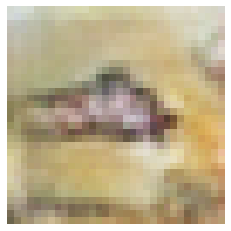

In [55]:
model = load_model('generator_model_010.h5')

latent_points = generate_latent_points(100,100)

X = model.predict(latent_points)

X = (X + 1) / 2.0

create_plot(X,1)

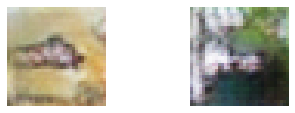

In [57]:
create_plot(X, 2)

In [32]:
X.shape

(100, 32, 32, 3)

In [31]:
X[1].shape

(32, 32, 3)

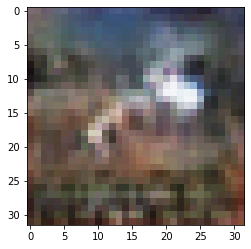

In [45]:
pyplot.imshow(X[0])

In [35]:
X.shape

(100, 32, 32, 3)

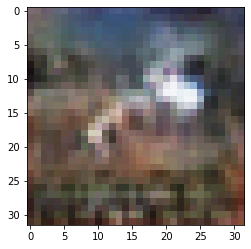

In [42]:
vector = np.asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

In [46]:
vector.shape

(1, 100)

In [47]:
latent_points.shape

(100, 100)

In [48]:
# define the discriminator model
modelx = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(modelx, dataset)

NameError: name 'train_discriminator' is not defined